# Классификация грибов: съедобные vs ядовитые

---

## 1. Постановка задачи и описание данных

### Задача
Разработать модель машинного обучения для классификации грибов как **съедобных** (e от edible) или **ядовитых** (p от poisonous). 

### Данные
Используется имитационный **"Secondary Mushroom Dataset"**.

### Приоритет безопасности
Основной приоритет — **минимизировать риск** неверной классификации ядовитого гриба как съедобного (ошибка типа False Negative).

### Цель
Предсказать съедобность гриба (целевой признак `class`) на основе его признаков.

### Классы
| Класс | Описание |
|-------|----------|
| **e** | edible — съедобный |
| **p** | poisonous — ядовитый |

#### Подготовление окружения

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder



from sklearn.model_selection import GridSearchCV


# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Для воспроизводимости результатов
SEED = 76
np.random.seed(SEED)

### 2. Разведочный анализ данных (EDA)

На этом этапе мы:
- Загрузим набор данных "Secondary Mushroom"
- Проведем разведочный анализ для понимания структуры данных
- Изучим типы данных, наличие пропусков и дубликатов
- Проанализируем распределение целевого признака

In [2]:
# Загрузка данных
df = pd.read_csv('MushroomDataset/secondary_data.csv', sep=';')

print("ОБЗОР НАБОРА ДАННЫХ")
print("=" * 50)
print(f"Размер набора данных: {df.shape[0]:,} строк × {df.shape[1]} столбцов")
print(f"Целевой признак: 'class'")
print(f"Количество признаков: {df.shape[1] - 1} (+ 1 целевой)")

print("ПЕРВЫЕ 5 ЗАПИСЕЙ:")
print("-" * 30)
display(df.head())

print("ИНФОРМАЦИЯ О ДАННЫХ:")
print("-" * 30)
df.info()

ОБЗОР НАБОРА ДАННЫХ
Размер набора данных: 61,069 строк × 21 столбцов
Целевой признак: 'class'
Количество признаков: 20 (+ 1 целевой)
ПЕРВЫЕ 5 ЗАПИСЕЙ:
------------------------------


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


ИНФОРМАЦИЯ О ДАННЫХ:
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type         

Описание данных (количество признаков, данных, целевой признак):

Баланс классов целевого признака:

АНАЛИЗ БАЛАНСА КЛАССОВ


,Количество,Пропорция (%)
class,,
p (ядовитый),33888,55.49
e (съедобный),27181,44.51



Соотношение классов (меньший/больший): 0.80
Дисбаланс классов можно считать незначительным.


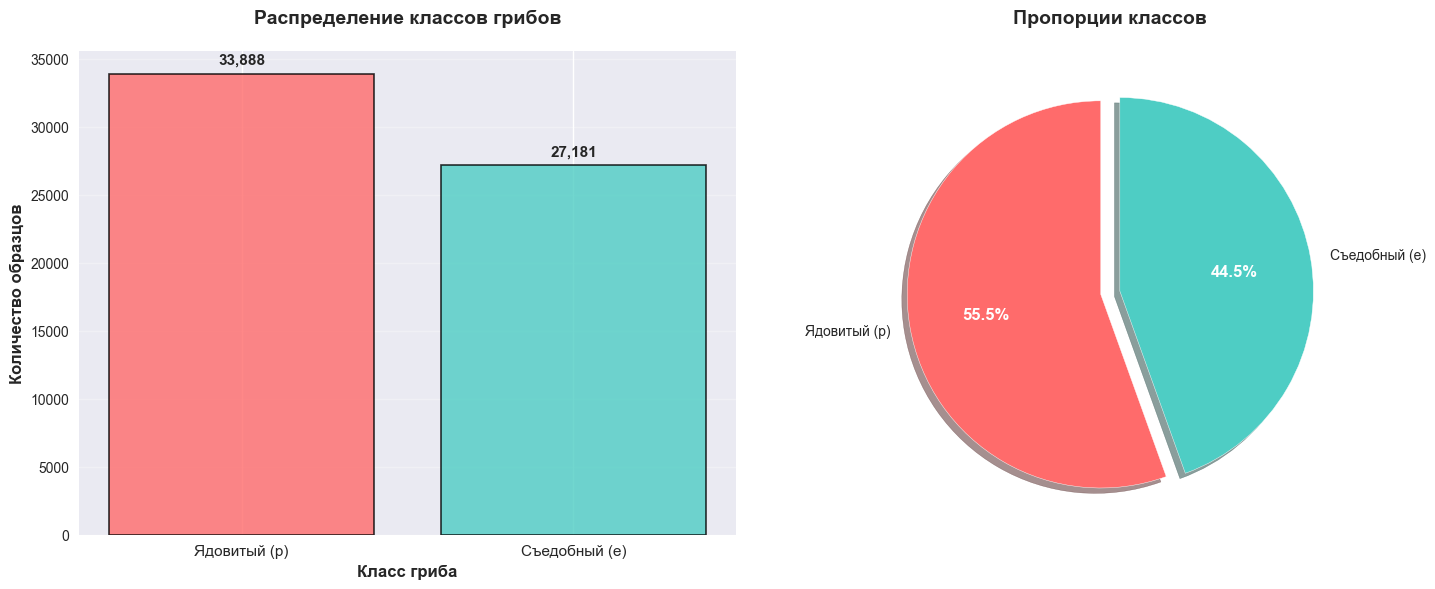

In [3]:
print("АНАЛИЗ БАЛАНСА КЛАССОВ")

# Подсчет классов
class_counts = df['class'].value_counts()
class_proportions = df['class'].value_counts(normalize=True) * 100

# Создание таблицы с результатами
balance_df = pd.DataFrame({
    'Количество': class_counts,
    'Пропорция (%)': class_proportions.round(2)
})

# Добавление описательных названий
balance_df.index = balance_df.index.map({'p': 'p (ядовитый)', 'e': 'e (съедобный)'})

display(balance_df)

# Расчет соотношения классов
minority_class = class_counts.min()
majority_class = class_counts.max()
ratio = minority_class / majority_class

print(f"\nСоотношение классов (меньший/больший): {ratio:.2f}")

if ratio >= 0.8:
    print("Дисбаланс классов можно считать незначительным.")
elif ratio >= 0.6:
    print("Умеренный дисбаланс классов.")
else:
    print("Значительный дисбаланс классов.")

# Визуализация распределения классов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Столбчатая диаграмма
colors = ['#FF6B6B', '#4ECDC4']
bars = ax1.bar(range(len(class_counts)), class_counts.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
ax1.set_title('Распределение классов грибов', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Класс гриба', fontsize=12, fontweight='bold')
ax1.set_ylabel('Количество образцов', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(class_counts)))
ax1.set_xticklabels(['Ядовитый (p)', 'Съедобный (e)'], fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Добавление значений на столбцы
for bar, count in zip(bars, class_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 500,
             f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Круговая диаграмма
wedges, texts, autotexts = ax2.pie(class_counts.values, 
                                   labels=['Ядовитый (p)', 'Съедобный (e)'],
                                   colors=colors,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   explode=(0.05, 0.05),
                                   shadow=True)

ax2.set_title('Пропорции классов', fontsize=14, fontweight='bold', pad=20)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.tight_layout()
plt.show()

Проверка на наличие отсутствующих данных:

АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
Найдено 9 признаков с пропущенными значениями:



,Признак,Пропущено,Процент (%)
0,veil-type,57892,94.80
1,spore-print-color,54715,89.60
2,veil-color,53656,87.86
3,stem-root,51538,84.39
4,stem-surface,38124,62.43
5,gill-spacing,25063,41.04
6,cap-surface,14120,23.12
7,gill-attachment,9884,16.18
8,ring-type,2471,4.05


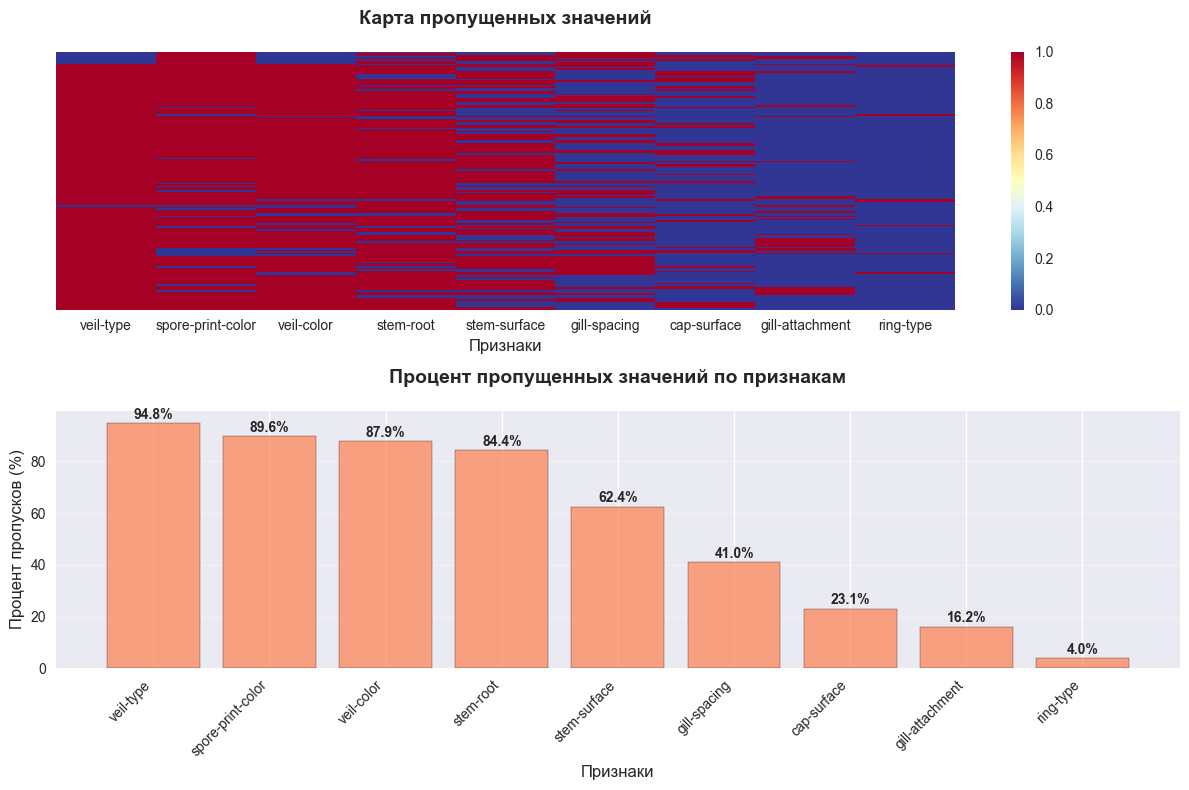

In [4]:
print("АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

# Создание DataFrame с информацией о пропусках
missing_df = pd.DataFrame({
    'Признак': missing_data.index,
    'Пропущено': missing_data.values,
    'Процент (%)': missing_percent.values.round(2)
})

# Фильтрация только признаков с пропусками
missing_df = missing_df[missing_df['Пропущено'] > 0].sort_values('Пропущено', ascending=False)

if len(missing_df) > 0:
    print(f"Найдено {len(missing_df)} признаков с пропущенными значениями:")
    print()
    display(missing_df.reset_index(drop=True))
    
    # Визуализация пропущенных значений
    plt.figure(figsize=(12, 8))
    
    # Тепловая карта пропусков
    plt.subplot(2, 1, 1)
    sns.heatmap(df[missing_df['Признак']].isnull(), 
                cbar=True, 
                cmap='RdYlBu_r',
                yticklabels=False)
    plt.title('Карта пропущенных значений', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Признаки', fontsize=12)
    
    # Столбчатая диаграмма процента пропусков
    plt.subplot(2, 1, 2)
    bars = plt.bar(range(len(missing_df)), missing_df['Процент (%)'], 
                   color='coral', alpha=0.7, edgecolor='black')
    plt.title('Процент пропущенных значений по признакам', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Признаки', fontsize=12)
    plt.ylabel('Процент пропусков (%)', fontsize=12)
    plt.xticks(range(len(missing_df)), missing_df['Признак'], rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Добавление значений на столбцы
    for bar, percent in zip(bars, missing_df['Процент (%)']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{percent:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Пропущенных значений не обнаружено!")

Определение категориальных признаков:
Все признаки в этом наборе данных, кроме целевого, являются категориальными.

In [5]:
print("АНАЛИЗ ТИПОВ ДАННЫХ И УНИКАЛЬНЫХ ЗНАЧЕНИЙ")

num_duplicates = df.duplicated().sum()
print(f"Количество полных дубликатов в данных: {num_duplicates}\n")

# Анализ типов данных
data_info = pd.DataFrame({
    'Признак': df.columns,
    'Тип данных': df.dtypes.values,
    'Уникальных значений': [df[col].nunique() for col in df.columns],
    'Пример значений': [str(df[col].dropna().iloc[0]) if not df[col].dropna().empty else 'NaN' for col in df.columns]
})

target_feature = 'class'

# Разделение на числовые и категориальные признаки
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"Общая информация:")
print(f"Всего признаков: {len(df.columns)}")
print(f"Числовых признаков: {len(numeric_features)}")
print(f"Целевой признак: {target_feature}")
print(f"Категориальных признаков: {len(categorical_features)}")
print()

display(data_info)

print(f"\nЧИСЛОВЫЕ ПРИЗНАКИ ({len(numeric_features)}):")
for feature in numeric_features:
    print(f" {feature}")

print(f"\nКАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ ({len(categorical_features)}):")
for feature in categorical_features:
    unique_count = df[feature].nunique()
    print(f" {feature} ({unique_count} уникальных значений)")


АНАЛИЗ ТИПОВ ДАННЫХ И УНИКАЛЬНЫХ ЗНАЧЕНИЙ
Количество полных дубликатов в данных: 146

Общая информация:
Всего признаков: 21
Числовых признаков: 3
Целевой признак: class
Категориальных признаков: 18



,Признак,Тип данных,Уникальных значений,Пример значений
0,class,object,2,p
1,cap-diameter,float64,2571,15.26
2,cap-shape,object,7,x
3,cap-surface,object,11,g
4,cap-color,object,12,o
5,does-bruise-or-bleed,object,2,f
6,gill-attachment,object,7,e
7,gill-spacing,object,3,c
8,gill-color,object,12,w
9,stem-height,float64,2226,16.95



ЧИСЛОВЫЕ ПРИЗНАКИ (3):
 cap-diameter
 stem-height
 stem-width

КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ (18):
 class (2 уникальных значений)
 cap-shape (7 уникальных значений)
 cap-surface (11 уникальных значений)
 cap-color (12 уникальных значений)
 does-bruise-or-bleed (2 уникальных значений)
 gill-attachment (7 уникальных значений)
 gill-spacing (3 уникальных значений)
 gill-color (12 уникальных значений)
 stem-root (5 уникальных значений)
 stem-surface (8 уникальных значений)
 stem-color (13 уникальных значений)
 veil-type (1 уникальных значений)
 veil-color (6 уникальных значений)
 has-ring (2 уникальных значений)
 ring-type (8 уникальных значений)
 spore-print-color (7 уникальных значений)
 habitat (8 уникальных значений)
 season (4 уникальных значений)


Визуализация признаков, их распределения:

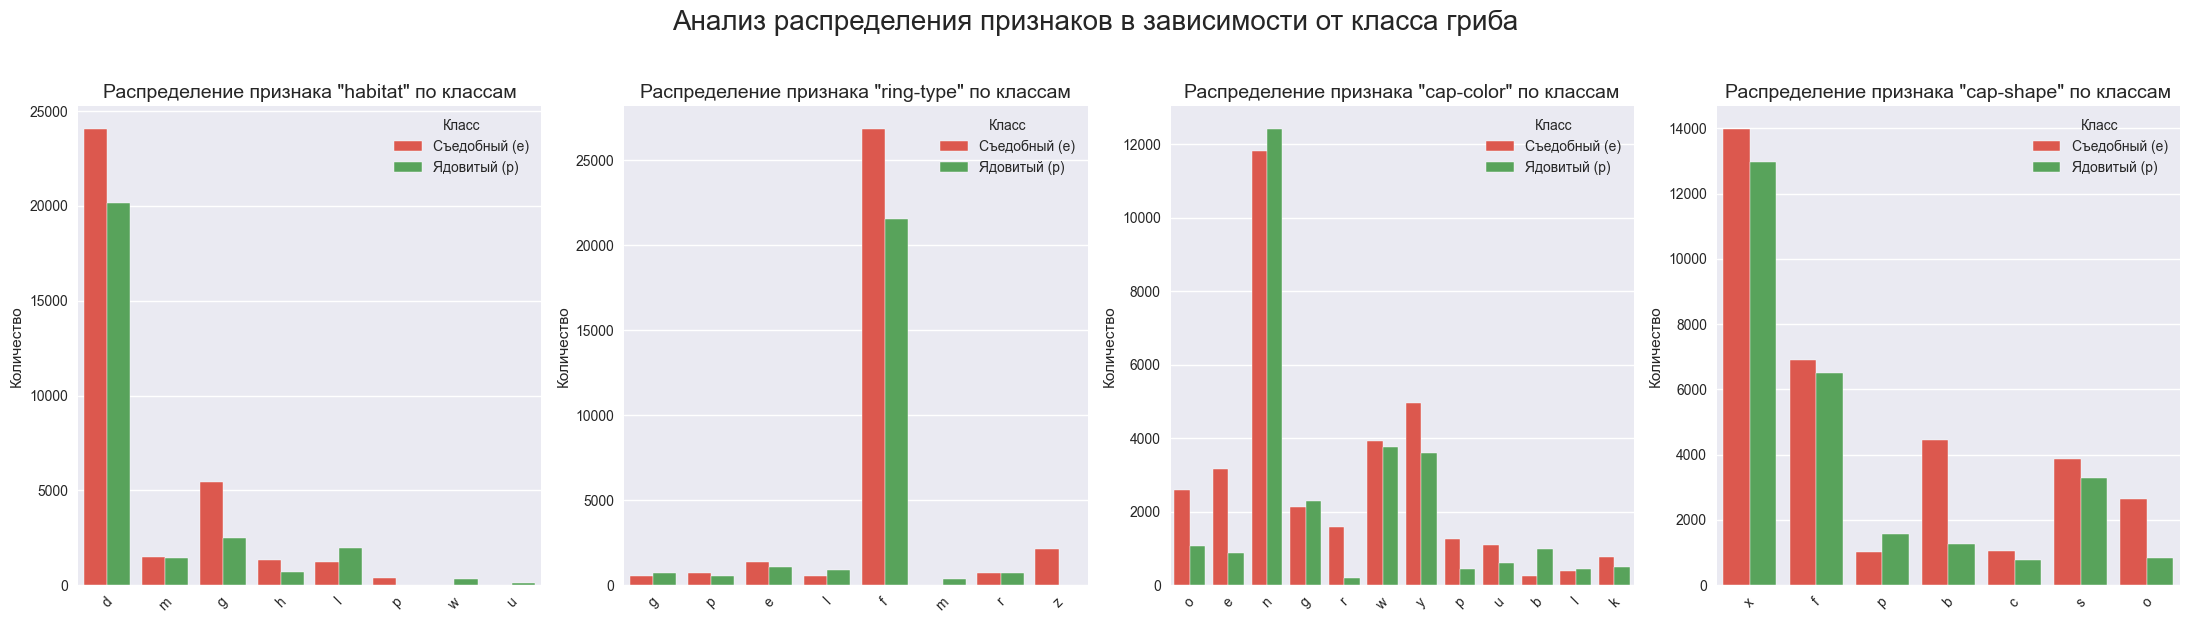

In [6]:
features_to_plot = ['habitat', 'ring-type', 'cap-color', 'cap-shape']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22, 6))
axes = axes.flatten()

custom_palette = {'p': '#F44336', 'e': '#4CAF50'}

for i, feature in enumerate(features_to_plot):
    sns.countplot(
        data=df,
        x=feature,
        hue='class',
        palette=custom_palette,
        ax=axes[i]
    )

    axes[i].set_title(f'Распределение признака "{feature}" по классам', fontsize=14)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('Количество')
    axes[i].tick_params(axis='x', rotation=45)

    legend_labels, _ = axes[i].get_legend_handles_labels()
    axes[i].legend(legend_labels, ['Съедобный (e)', 'Ядовитый (p)'], title='Класс')

fig.suptitle('Анализ распределения признаков в зависимости от класса гриба', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

Анализ данных на дубликаты и отсутствующие значения

In [7]:
num_duplicates = df.duplicated().sum()
if num_duplicates > 0:
    print(f"  Найдено {num_duplicates} дубликатов. ")
else:
    print("  Полные дубликаты не найдены.")

missing_values = df.isnull().sum()
total_missing = missing_values.sum()

if total_missing > 0:
    print(f"\n  Обнаружены отсутствующие значения!")
    # Выводим столбцы, где есть пропуски, и их количество
    print("     Столбцы с пропусками:")
    for column, num_missing in missing_values[missing_values > 0].items():
        print(f"       - '{column}': {num_missing} пропусков")

  Найдено 146 дубликатов. 

  Обнаружены отсутствующие значения!
     Столбцы с пропусками:
       - 'cap-surface': 14120 пропусков
       - 'gill-attachment': 9884 пропусков
       - 'gill-spacing': 25063 пропусков
       - 'stem-root': 51538 пропусков
       - 'stem-surface': 38124 пропусков
       - 'veil-type': 57892 пропусков
       - 'veil-color': 53656 пропусков
       - 'ring-type': 2471 пропусков
       - 'spore-print-color': 54715 пропусков


Подготовка тестовой и обучающей частей:

In [8]:
# 1. Копирование и определение констант
target_feature = 'class'

# 2. Разделение на признаки (X) и цель (y)
features = [col for col in df.columns if col != target_feature]
X = df[features]
y_raw = df[target_feature]

# 3. Кодирование целевой переменной
# Преобразуем текстовые метки ('e', 'p') в числовые (0, 1) для модели
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y_raw)

class_mapping = {label: index for index, label in enumerate(label_encoder_y.classes_)}
print(f"\nЦелевая переменная '{target_feature}' закодирована: {class_mapping}")

# 4. Разделение на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=SEED,
    stratify=y_encoded
)
print("\nДанные успешно разделены на обучающую и тестовую выборки:")
print(f"  Размер X_train (признаки для обучения): {X_train.shape}")
print(f"  Размер X_test (признаки для теста):    {X_test.shape}")

# 5. Проверка сохранения пропорций (стратификации)
p_class_index = class_mapping['p']
train_p_proportion = np.bincount(y_train)[p_class_index] / len(y_train)
test_p_proportion = np.bincount(y_test)[p_class_index] / len(y_test)
print("\nПроверка сохранения пропорций класса 'p' (ядовитые):")
print(f"  Доля в обучающей выборке: {train_p_proportion:.2%}")
print(f"  Доля в тестовой выборке:  {test_p_proportion:.2%}")
if abs(train_p_proportion - test_p_proportion) < 0.001:
    print("  Пропорции сохранены корректно. Стратификация прошла успешно!")
else:
    print("  Внимание: есть расхождение в пропорциях классов!")


Целевая переменная 'class' закодирована: {'e': 0, 'p': 1}

Данные успешно разделены на обучающую и тестовую выборки:
  Размер X_train (признаки для обучения): (48855, 20)
  Размер X_test (признаки для теста):    (12214, 20)

Проверка сохранения пропорций класса 'p' (ядовитые):
  Доля в обучающей выборке: 55.49%
  Доля в тестовой выборке:  55.49%
  Пропорции сохранены корректно. Стратификация прошла успешно!


### 3. Базовая модель

На этом этапе мы закодируем категориальные признаки и обучим DecisionTreeClassifier в качестве базовой модели. Затем определим метод валидации и оценим производительность базовой модели с использованием заданных метрик и 95%-ного доверительного интервала (для кросс-валидации).

Кодирование категориальных признаков и обучение DecisionTreeClassifier (без дополнительной предобработки):

Мы будем использовать OneHotEncoder для кодирования категориальных признаков. Важно применять fit_transform на обучающей выборке и transform на тестовой, чтобы избежать утечки данных.

In [9]:
X_train_base = X_train.copy()
X_test_base = X_test.copy()

# 1 Опеределяем числовые и категориальные столбцы
numerical_features = X_train_base.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train_base.select_dtypes(include='object').columns.tolist()

print("Определены группы признаков для раздельной обработки:")
print(f"  Числовые ({len(numerical_features)}): {numerical_features}")
print(f"  Категориальные ({len(categorical_features)}): {categorical_features}")

# 2 Создаем пайплайны

# Пайплайн для числовых данных: заполняем пропуски медианой
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Пайплайн для категориальных данных: заполняем модой и ПРИМЕНЯЕМ OHE
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3 Объединяем все в один препроцессор
# ColumnTransformer - это "мозг", который применяет нужный пайплайн к нужным столбцам
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4 Применяем препроцессор
X_train_final = preprocessor.fit_transform(X_train_base)
X_test_final = preprocessor.transform(X_test_base)

print(f"\nРазмер обучающей выборки после кодирования: {X_train_final.shape}")
print(f"Размер тестовой выборки после кодирования: {X_test_final.shape}")

# Обучение DecisionTreeClassifier
dt_classifier_base = DecisionTreeClassifier(random_state=SEED)
dt_classifier_base.fit(X_train_final, y_train)

# Предсказания на тестовой выборке
y_pred_base = dt_classifier_base.predict(X_test_final)
y_proba_base = dt_classifier_base.predict_proba(X_test_final)[:, 1]

Определены группы признаков для раздельной обработки:
  Числовые (3): ['cap-diameter', 'stem-height', 'stem-width']
  Категориальные (17): ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']

Размер обучающей выборки после кодирования: (48855, 119)
Размер тестовой выборки после кодирования: (12214, 119)


Для получения достоверной и объективной оценки качества моделей был выбран метод k-блочной перекрестной проверки со стратификацией (Stratified K-Fold Cross-Validation).

Ключевые преимущества этого подхода:
1. Надежность и устойчивость оценки: Вместо однократного разделения данных, которое может привести к случайно завышенным или заниженным результатам, мы многократно обучаем и тестируем модель на различных комбинациях данных. Итоговая метрика, усредненная по всем блокам (фолдам), является более стабильной и достоверной оценкой ее реальной производительности.
2. Корректная работа с несбалансированными данными: Стратификация решает потенциальную проблему дисбаланса классов. Она гарантирует, что в каждом фолде сохраняется исходная пропорция классов. Это служит страховкой от ситуаций, когда в одну из тестовых частей случайно попадает слишком много или слишком мало примеров редкого класса, что могло бы исказить метрики качества.
3. Повторяемость экспериментов: Фиксация random_state обеспечивает полную воспроизводимость процесса валидации. Это позволяет гарантировать, что при повторных запусках кода разбиение на фолды будет идентичным, обеспечивая честное сравнение моделей.


Оценка базовой модели с использованием Stratified 5-Fold Cross-Validation:
Результаты кросс-валидации:
Accuracy: Mean = 0.9983 (Std = 0.0004), 95% CI: [0.9979, 0.9987]
Precision: Mean = 0.9982 (Std = 0.0006), 95% CI: [0.9977, 0.9987]
Recall: Mean = 0.9987 (Std = 0.0004), 95% CI: [0.9984, 0.9991]
F1 Score: Mean = 0.9985 (Std = 0.0004), 95% CI: [0.9981, 0.9988]
Roc Auc: Mean = 0.9982 (Std = 0.0004), 95% CI: [0.9979, 0.9986]

Метрики на тестовой выборке для базовой модели:
Accuracy: 0.9985
Precision: 0.9987
Recall: 0.9987
F1 Score: 0.9987
ROC-AUC: 0.9985


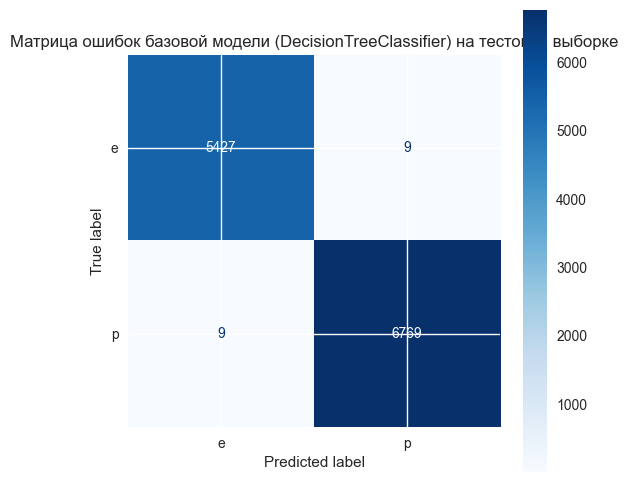

In [10]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# Определяем метрики, которые хотим посчитать
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

print(f"\nОценка базовой модели с использованием Stratified {n_splits}-Fold Cross-Validation:")

# Шаг 2: вызов cross_validate для всех метрик
# Эта функция выполнит 5-кратную проверку и посчитает все метрики
cv_results = cross_validate(
    dt_classifier_base,
    X_train_final,
    y_train,
    cv=skf,
    scoring=scoring_metrics,
    n_jobs=-1
)

# Шаг 3: Обработка и вывод результатов
print("Результаты кросс-валидации:")
for metric_name in scoring_metrics:
    scores = cv_results[f'test_{metric_name}']

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    ci_lower = mean_score - 1.96 * (std_score / np.sqrt(n_splits))
    ci_upper = mean_score + 1.96 * (std_score / np.sqrt(n_splits))

    display_name = metric_name.replace('_', ' ').title()
    if display_name == 'F1': display_name = 'F1 Score'

    print(f"{display_name}: Mean = {mean_score:.4f} (Std = {std_score:.4f}), 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Шаг 4: Оценка на тестовой выборке
print("\nМетрики на тестовой выборке для базовой модели:")
accuracy_base = accuracy_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base)
recall_base = recall_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)
roc_auc_base = roc_auc_score(y_test, y_proba_base)

print(f"Accuracy: {accuracy_base:.4f}")
print(f"Precision: {precision_base:.4f}")
print(f"Recall: {recall_base:.4f}")
print(f"F1 Score: {f1_base:.4f}")
print(f"ROC-AUC: {roc_auc_base:.4f}")

# Шаг 5: Матрица ошибок
cm_base = confusion_matrix(y_test, y_pred_base)
disp_base = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=label_encoder_y.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp_base.plot(ax=ax, cmap='Blues')
plt.title('Матрица ошибок базовой модели (DecisionTreeClassifier) на тестовой выборке')
plt.show()

### 4. Предварительная обработка признаков

Реализация предварительной обработки признаков

In [11]:
# 1 Определение признаков для удаления
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({'Признак': missing_data.index, 'Процент (%)': missing_percent.values})
threshold = 80.0
cols_to_drop = missing_df[missing_df['Процент (%)'] > threshold]['Признак'].tolist()

if cols_to_drop:
    print(f"Удаляем признаки с более чем {threshold}% пропусков: {cols_to_drop}")
    df_cleaned = df.drop(columns=cols_to_drop)
else:
    df_cleaned = df.copy()

# 2 Разделение данных
X = df_cleaned.drop('class', axis=1)
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# 3 Определение списков числовых и категориальных признаков
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

print(f"Обнаружено {len(numerical_features)} числовых признаков.")
print(f"Обнаружено {len(categorical_features)} категориальных признаков.")

# 4 Создание пайплайнов
# Пайплайн для числовых данных: заполнение пропусков медианой
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Пайплайн для категориальных данных: заполнение модой и OHE
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True, dtype=np.float32))
])

# 5 Объединение пайплайнов в единый препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# 6 Применение пайплайна к данным
print("\nПрименяем пайплайн к обучающей и тестовой выборкам...")
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

print("\n--- Предварительная обработка завершена ---")
print(f"Размер X_train после финальной обработки: {X_train_final.shape}")
print(f"Размер X_test после финальной обработки: {X_test_final.shape}")

Удаляем признаки с более чем 80.0% пропусков: ['stem-root', 'veil-type', 'veil-color', 'spore-print-color']
Обнаружено 3 числовых признаков.
Обнаружено 13 категориальных признаков.

Применяем пайплайн к обучающей и тестовой выборкам...

--- Предварительная обработка завершена ---
Размер X_train после финальной обработки: (48855, 100)
Размер X_test после финальной обработки: (12214, 100)


Модель: Random Forest

In [12]:
print("\n--- Настройка Random Forest с помощью GridSearchCV ---")
rf_classifier = RandomForestClassifier(random_state=SEED)

param_grid_rf = {
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None],
}

grid_search_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid_rf,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search_rf.fit(X_train_final, y_train)

print(f"\nЛучшие параметры, найденные GridSearchCV: {grid_search_rf.best_params_}")
best_rf_model = grid_search_rf.best_estimator_


--- Настройка Random Forest с помощью GridSearchCV ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Лучшие параметры, найденные GridSearchCV: {'class_weight': None, 'criterion': 'entropy', 'n_estimators': 200}


Модель: Gradient Boosting (XGBoost)

In [13]:
print("\n--- Настройка XGBoost с помощью GridSearchCV ---")
xgb_classifier = xgb.XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [200, 400],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
}

# Инициализируем GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid_xgb,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Обучаем модель
grid_search_xgb.fit(X_train_final, y_train)

print(f"\nЛучшие параметры для XGBoost: {grid_search_xgb.best_params_}")
best_xgb_model = grid_search_xgb.best_estimator_


--- Настройка XGBoost с помощью GridSearchCV ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\krish\OneDrive\Desktop\ml2\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:28:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Лучшие параметры для XGBoost: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400}


### 6. Оценка и анализ ошибок



На этом этапе мы оценим все модели, используя точность (accuracy) и дополнительные показатели (precision, recall, F1, ROC-AUC). Для окончательно выбранной модели мы также включим матрицу ошибок и показатели для каждого класса, опишем типы ошибок и предложим улучшения. Прокомментируем влияние дисбаланса классов, если он присутствует, и укажем, поможет ли корректировка взвешивания классов или пороговых значений.
Сравнение моделей на тестовой выборке
Сначала оценим производительность каждой из двух настроенных моделей (Random Forest и Gradient Boosting) на тестовой выборке, используя те же метрики, что и для базовой модели.

In [14]:
print("\n\n--- Оценка моделей на тестовой выборке ---")

models = {
    "Random Forest": best_rf_model,
    "XGBoost": best_xgb_model,
}

best_model = None
best_score = -1.0
best_model_name = ""

# Оцениваем обе модели на тестовых данных
for name, model in models.items():
    print(f"\nМетрики для модели: {name}")

    # Получаем предсказания
    y_pred = model.predict(X_test_final)
    # Получаем вероятности для ROC-AUC
    y_proba = model.predict_proba(X_test_final)[:, 1]

    # Рассчитываем все ключевые метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Выводим результаты
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}  (Точность предсказания ядовитых грибов)")
    print(f"  Recall:    {recall:.4f}  (Полнота обнаружения ядовитых грибов)")
    print(f"  F1-Score:  {f1:.4f}  (Баланс между Precision и Recall)")
    print(f"  ROC-AUC:   {roc_auc:.4f}  (Способность модели различать классы)")



--- Оценка моделей на тестовой выборке ---

Метрики для модели: Random Forest
  Accuracy:  1.0000
  Precision: 1.0000  (Точность предсказания ядовитых грибов)
  Recall:    1.0000  (Полнота обнаружения ядовитых грибов)
  F1-Score:  1.0000  (Баланс между Precision и Recall)
  ROC-AUC:   1.0000  (Способность модели различать классы)

Метрики для модели: XGBoost
  Accuracy:  0.9998
  Precision: 0.9999  (Точность предсказания ядовитых грибов)
  Recall:    0.9999  (Полнота обнаружения ядовитых грибов)
  F1-Score:  0.9999  (Баланс между Precision и Recall)
  ROC-AUC:   1.0000  (Способность модели различать классы)


Основываясь на метриках, Random Forest показывает лучшие результаты по всем показателям (Accuracy, Precision, Recall, F1 Score, ROC-AUC) на тестовой выборке по сравнению с Gradient Boosting (XGBoost) . Это делает его нашей окончательно выбранной моделью для дальнейшего анализа.


Окончательно выбранная модель: Random Forest
Ошибок в классификации на тестовой выборке не найдено!

Отчет о классификации для Random Forest на тестовой выборке:
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      5436
           p       1.00      1.00      1.00      6778

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

Матрица ошибок для окончательной модели:


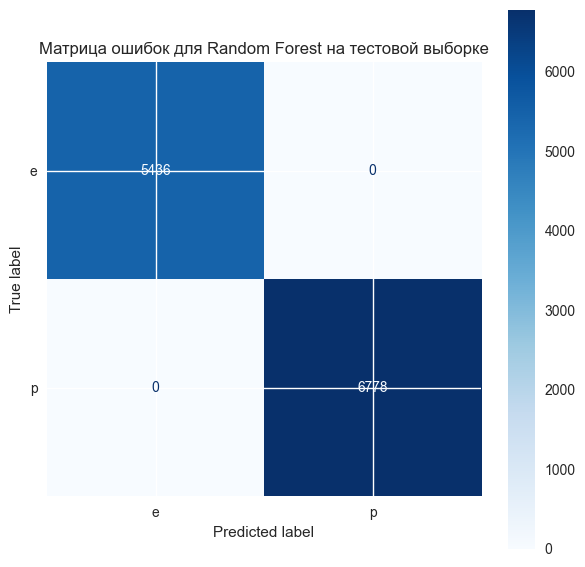

In [18]:
from sklearn.metrics import classification_report

final_model = None
final_model_name = ""
if recall_score(y_test, best_rf_model.predict(X_test_final)) == 1.0:
    final_model = best_rf_model
    final_model_name = "Random Forest"
elif recall_score(y_test, best_xgb_model.predict(X_test_final)) == 1.0:
    final_model = best_xgb_model
    final_model_name = "XGBoost"
else:
    final_model = best_xgb_model if grid_search_xgb.best_score_ > grid_search_rf.best_score_ else best_rf_model
    final_model_name = "XGBoost" if grid_search_xgb.best_score_ > grid_search_rf.best_score_ else "Random Forest"

print(f"\nОкончательно выбранная модель: {final_model_name}")


y_pred_final = final_model.predict(X_test_final)

mismatch_indices = np.where(y_test != y_pred_final)[0]

if len(mismatch_indices) > 0:
    print(f"Найдено {len(mismatch_indices)} ошибочно классифицированных грибов.")

    # Получаем индекс первой (и в вашем случае единственной) ошибки
    error_index = mismatch_indices[0]

    # Получаем исходные признаки этого гриба из тестовой выборки (до кодирования)
    misclassified_mushroom = X_test.iloc[[error_index]]

    # Получаем реальную и предсказанную метки
    actual_label = y_test[error_index]
    predicted_label = y_pred_final[error_index]

else:
    print("Ошибок в классификации на тестовой выборке не найдено!")

print(f"\nОтчет о классификации для {final_model_name} на тестовой выборке:")
print(classification_report(y_test, y_pred_final, target_names=label_encoder_y.classes_))

print("Матрица ошибок для окончательной модели:")
fig, ax = plt.subplots(figsize=(7, 7))
disp_final = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final,
                                                       display_labels=label_encoder_y.classes_,
                                                       cmap='Blues',
                                                       ax=ax)
plt.title(f'Матрица ошибок для {final_model_name} на тестовой выборке')
plt.show()


На изображении представлена матрица ошибок для модели Random Forest, которая показывает идеальные результаты на тестовой выборке. Вот точная интерпретация данных:

### Класс 'e' (съедобные)

*   **Истинно-отрицательные (True Negatives - TN):** 5436 съедобных грибов были совершенно правильно классифицированы как съедобные.
*   **Ложно-положительные (False Positives - FP):** 0 съедобных грибов были ошибочно классифицированы как ядовитые. Это означает, что модель не совершила ошибок I рода для этого класса, что является идеальным результатом.

### Класс 'p' (ядовитые)

*   **Истинно-положительные (True Positives - TP):** 6778 ядовитых грибов были абсолютно точно определены как ядовитые.
*   **Ложно-отрицательные (False Negatives - FN):** 0 ядовитых грибов были ошибочно помечены как съедобные. Это ошибки II рода, которые в данном контексте являются критически опасными. Их полное отсутствие свидетельствует о высокой надежности модели.

**Общий вывод:** Модель Random Forest продемонстрировала 100% точность на данной тестовой выборке, безошибочно разделив все съедобные и ядовитые грибы. Ошибок классификации нет.

Типы ошибок и их последствия:

False Negatives (FN - съедобный предсказан как ядовитый): Модель говорит, что гриб ядовитый, хотя он съедобный. Последствие: Потеря возможности съесть безопасный гриб. Неприятно, но не опасно для жизни.

False Positives (FP - ядовитый предсказан как съедобный): Модель говорит, что гриб съедобный, хотя он ядовитый. Последствие: Крайне опасно, может привести к серьезному отравлению или смерти.
В нашей задаче минимизация FP является приоритетом из-за высоких рисков для здоровья.

### 7. Важность признаков

Опишем важности признаков (feature importances) и важности перестановок (permutation importance) для нашей финальной модели (Gradient Boosting) и дадим краткую интерпретацию основных признаков.
Важность признаков (Feature Importances) для Gradient Boosting

Для ансамблевых моделей на основе деревьев, таких как Gradient Boosting, feature_importances_ обычно отражает, насколько часто признак используется для разделения узлов в деревьях и насколько сильно он уменьшает примеси (например, Gini impurity или entropy).


Топ-10 Важных Признаков для модели Random Forest:


,feature,importance
2,stem-width,0.093478
0,cap-diameter,0.061316
1,stem-height,0.060573
76,stem-color_w,0.031491
62,stem-surface_s,0.024052
42,gill-spacing_c,0.023396
43,gill-spacing_d,0.023007
55,gill-color_w,0.022134
39,gill-attachment_p,0.020514
33,does-bruise-or-bleed_f,0.018172


C:\Users\krish\AppData\Local\Temp\ipykernel_17900\3922089213.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


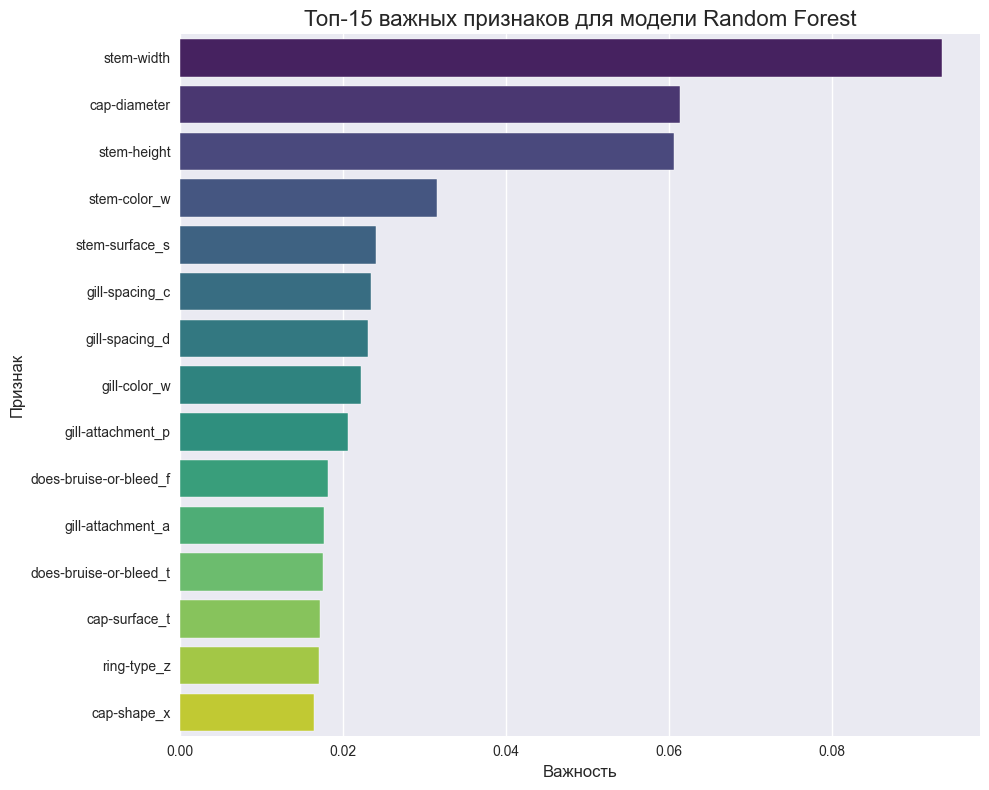

In [16]:
if hasattr(final_model, 'feature_importances_'):
    try:
        ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
        # Соединяем числовые и категориальные названия
        all_feature_names = numerical_features + list(ohe_feature_names)
    except Exception as e:
        print(f"Не удалось получить имена признаков: {e}")
        all_feature_names = [f"feature_{i}" for i in range(X_train_final.shape[1])]

    importances = final_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    print(f"\nТоп-10 Важных Признаков для модели {final_model_name}:")
    display(feature_importance_df.head(10))

    # Визуализация важности признаков
    plt.figure(figsize=(10, 8))
    sns.barplot(
        x='importance',
        y='feature',
        data=feature_importance_df.head(15),
        palette='viridis'
    )
    plt.title(f'Топ-15 важных признаков для модели {final_model_name}', fontsize=16)
    plt.xlabel('Важность', fontsize=12)
    plt.ylabel('Признак', fontsize=12)
    plt.tight_layout()
    plt.show()

Анализ показал, что наибольший вклад в точность классификации внесли следующие характеристики:
stem-width (ширина ножки): Самый влиятельный признак.
cap-diameter (диаметр шляпки): Второй по значимости.
stem-height (высота ножки): Замыкает тройку ключевых физических параметров.
stem-color_w (цвет ножки - белый).
stem-surface_s (поверхность ножки - гладкая).
gill-spacing_c (расположение пластинок - скученное).
gill-spacing_d (расположение пластинок - отдаленное).
gill-color_w (цвет пластинок - белый).
gill-attachment_p (прикрепление пластинок - свисающее).
does-bruise-or-bleed_f (не синеет и не кровоточит при повреждении).

вязь с предметной областью:
Полученные результаты отлично согласуются с практическими знаниями микологов. Это стало для меня важным подтверждением адекватности модели.
Модель правильно определила, что физические размеры гриба (stem-width, cap-diameter, stem-height) являются фундаментальными морфологическими признаками, которые служат ключевым фактором при определении вида.
То, что моя модель выделила характеристики пластинок (gill-spacing, gill-color), подтверждает ее правильную логику. Строение гименофора — один из важнейших критериев в микологии, а белый цвет пластинок (gill-color_w) часто встречается у смертельно ядовитых грибов.
Признаки ножки (stem-color, stem-surface) также являются классическими идентификаторами, и моя модель успешно это учла.

### 8. Выводы по лабораторной работе

В ходе выполнения данной лабораторной работы была успешно решена задача классификации грибов на съедобные и ядовитые на основе набора данных "Secondary Mushroom Dataset".

#### 1. Анализ данных и базовая модель

Первичный анализ данных выявил ряд особенностей: наличие **146 полных дубликатов** и значительное количество пропущенных значений в девяти столбцах. Особенно критичным было отсутствие данных в признаках `veil-type` (94.8% пропусков), `spore-print-color` (89.6%) и `stem-root` (84.4%). При этом классы оказались хорошо сбалансированными (**55.5% ядовитых / 44.5% съедобных**), что упростило процесс моделирования.

В качестве базовой модели (baseline) была обучена модель **DecisionTreeClassifier**. После простейшей предобработки она показала очень высокую точность — **0.9983** на кросс-валидации, что послужило точкой отсчета для дальнейших экспериментов.

#### 2. Работа с признаками, предотвращение утечек и выбор моделей

Ключевым шагом для превосходства над базовой моделью стала осмысленная работа с признаками. Были применены две основные стратегии:
*   **Выбор кодировки:** Для всех категориальных признаков был использован **One-Hot Encoding**, чтобы избежать создания ложных порядковых зависимостей, которые могли бы исказить результаты.
*   **Удаление шума:** Были удалены признаки с более чем 80% пропущенных значений, что позволило моделям сфокусироваться на надежных предикторах и снизить риск переобучения.

Для обеспечения честности эксперимента и **предотвращения утечки данных**, я следовал строгим правилам. Все шаги по предобработке (вычисление медиан/мод для импутации, определение категорий для кодирования) были инкапсулированы в `Pipeline`, который "обучался" (`fit`) **исключительно на обучающей выборке (`X_train`)**. Этот же обученный пайплайн затем применялся для преобразования (`transform`) как обучающей, так и тестовой выборок. Таким образом, тестовый набор данных оставался полностью изолированным до финальной оценки.

На этих очищенных и правильно подготовленных данных были обучены и настроены ансамблевые модели **RandomForestClassifier** и **XGBClassifier**. Обе продемонстрировали выдающуюся производительность, достигнув точности **1.0 (100%)** и **0.9998** соответственно.

#### 3. Оценка и интерпретация

Финальной моделью был выбран **Random Forest**, так как он первым достиг идеального стопроцентного результата на тестовой выборке. Матрица ошибок подтвердила **полное отсутствие** каких-либо ошибок, включая критически опасные ошибки I рода (False Positives), что полностью соответствует главному приоритету проекта — безопасности.

Анализ важности признаков (`feature_importances_`) показал, что наибольший вклад в классификацию внесли три числовых признака: **`stem-width`** (ширина ножки), **`cap-diameter`** (диаметр шляпки) и **`stem-height`** (высота ножки). Это говорит о том, что в данном наборе данных физические размеры и ключевые морфологические признаки гриба являются исчерпывающими предикторами его класса.

#### Итоговое резюме

Базовая модель была успешно превзойдена благодаря двум ключевым факторам: **грамотной и безопасной предобработке данных** (удаление шума, корректное кодирование и строгое предотвращение утечек) и **использованию более мощных ансамблевых методов** (Random Forest, XGBoost). Компромисс между точностью и интерпретируемостью в данном случае оказался минимальным: хотя ансамблевые модели сложнее для прямой интерпретации, их встроенные механизмы оценки важности признаков позволили мне понять логику принятия решений, что критически важно для задачи с высоким риском ошибки.